In [1]:
%cd 'Q:\Dropbox\python\QSim\'

Q:\Dropbox\python\QSim


In [2]:
from scipy.io import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [53]:
def cross(a, b):
    return [a[i]*b[i+1]-a[i+1]*b[i] for i in [1,-1,0]]

def div(X):
    divX = np.sum([(np.roll(X[i],-1,i)-np.roll(X[i],1,i))*0.5 for i in range(0,3)],0)
    
    divX[0,:,:] = np.sum([-1.5*X[i][0,:,:]+2*X[i][1,:,:]-0.5*X[i][2,:,:] for i in range(0,3)],0)
    divX[-1,:,:] = np.sum([1.5*X[i][-1,:,:]-2*X[i][-2,:,:]+0.5*X[i][-3,:,:] for i in range(0,3)],0)
    divX[:,0,:] = np.sum([-1.5*X[i][:,0,:]+2*X[i][:,1,:]-0.5*X[i][:,2,:] for i in range(0,3)],0)
    divX[:,-1,:] = np.sum([1.5*X[i][:,-1,:]-2*X[i][:,-2,:]+0.5*X[i][:,-3,:] for i in range(0,3)],0)
    divX[:,:,0] = np.sum([-1.5*X[i][:,:,0]+2*X[i][:,:,1]-0.5*X[i][:,:,2] for i in range(0,3)],0)
    divX[:,:,-1] = np.sum([1.5*X[i][:,:,-1]-2*X[i][:,:,-2]+0.5*X[i][:,:,-3] for i in range(0,3)],0)
    
    return divX

def jacobian(X):
    J = [[(np.roll(X[i],-1,j)-np.roll(X[i],1,j))*0.5 for j in range(0,3)] for i in range(0,3)]
    for i in range(0,3):
        J[i][0][0,:,:] = -1.5*X[i][0,:,:]+2*X[i][1,:,:]-0.5*X[i][2,:,:]
        J[i][0][-1,:,:] = 1.5*X[i][-1,:,:]-2*X[i][-2,:,:]+0.5*X[i][-3,:,:]
        J[i][1][:,0,:] = -1.5*X[i][:,0,:]+2*X[i][:,1,:]-0.5*X[i][:,2,:]
        J[i][1][:,-1,:] = 1.5*X[i][:,-1,:]-2*X[i][:,-2,:]+0.5*X[i][:,-3,:]
        J[i][2][:,:,0] = -1.5*X[i][:,:,0]+2*X[i][:,:,1]-0.5*X[i][:,:,2]
        J[i][2][:,:,-1] = 1.5*X[i][:,:,-1]-2*X[i][:,:,-2]+0.5*X[i][:,:,-3]
    return J

def hessian(X):
    J = jacobian(X)   
    H = [[[(-2*X[i] + np.roll(X[i],-1,k)+np.roll(X[i],1,k)) if k == j else 
           (np.roll(J[i][j],-1,k)-np.roll(J[i][j],1,k))*0.5 for k in range(0,j+1)] for j in range(0,3)] for i in range(0,3)]
    
    for i in range(0,3):
        H[i][0][0][0,:,:] = 2*X[i][0,:,:]-5*X[i][1,:,:]+4*X[i][2,:,:]-X[i][3,:,:]
        H[i][0][0][-1,:,:] = 2*X[i][-1,:,:]-5*X[i][-2,:,:]+4*X[i][-3,:,:]-X[i][-4,:,:]
        H[i][1][1][:,0,:] = 2*X[i][:,0,:]-5*X[i][:,1,:]+4*X[i][:,2,:]-X[i][:,3,:]
        H[i][1][1][:,-1,:] = 2*X[i][:,-1,:]-5*X[i][:,-2,:]+4*X[i][:,-3,:]-X[i][:,-4,:]
        H[i][2][2][:,:,0] = 2*X[i][:,:,0]-5*X[i][:,:,1]+4*X[i][:,:,2]-X[i][:,:,3]
        H[i][2][2][:,:,-1] = 2*X[i][:,:,-1]-5*X[i][:,:,-2]+4*X[i][:,:,-3]-X[i][:,:,-4]
        
        for j in range(1,3):
            H[i][j][0][0,:,:] = -1.5*J[i][j][0,:,:]+2*J[i][j][1,:,:]-0.5*J[i][j][2,:,:]
            H[i][j][0][-1,:,:] = 1.5*J[i][j][-1,:,:]-2*J[i][j][-2,:,:]+0.5*J[i][j][-3,:,:]
        
        H[i][2][1][:,0,:] = -1.5*J[i][2][:,0,:]+2*J[i][2][:,1,:]-0.5*J[i][2][:,2,:]
        H[i][2][1][:,-1,:] = 1.5*J[i][2][:,-1,:]-2*J[i][2][:,-2,:]+0.5*J[i][2][:,-3,:]        
    
    return (H, J)    

def det(a):
    return np.sum([a[0][i-1]*(a[1][i]*a[2][i+1]-a[1][i+1]*a[2][i]) for i in [1,-1,0]],0)

def rot(B, X, P):
    hes = hessian(X)
    J = hes[1]
    H = hes[0]
    detJ = det(J)
    Jb = [[(J[i][j]*J[i+1][j+1] - J[i+1][j]*J[i][j+1])/detJ for j in [-2,-1,0]] for i in [1,-1,0]]
    dB = [np.gradient(B[i]) for i in range(0,3)]
    Bx = [np.sum([J[i][j]*B[j] for j in range(0,3)]/detJ,0) for i in range(0,3)]
    
    #B2 = np.sum(np.power(B,2),0)
    #Bx2 = np.sum(np.power(Bx,2),0)
  
    #DdetJ = [det([[H[i][j][0],J[i][1],J[i][2]] for i in range(0,3)])+
    #        det([[J[i][0],H[i][max(j,1)][min(j,1)],J[i][2]] for i in range(0,3)])+
    #        det([[J[i][0],J[i][1],H[i][max(j,2)][min(j,2)]] for i in range(0,3)]) for j in range(0,3)]

    dP = np.gradient(P)
    
    dBx = [[(np.sum([J[i][k]*dB[k][j] + H[i][max(k,j)][min(k,j)]*B[k] for k in range(0,3)],0) -
                dP[j]*Bx[i])/P for j in range(0,3)] for i in range(0,3)]
    
    rotB = [np.sum([Jb[i][j]*dBx[i+1][j]-Jb[i+1][j]*dBx[i][j] for j in range(0,3)],0) for i in [1,-1,0]]
    
    force = [np.sum([B[j]*dBx[i][j]/P - np.sum([Bx[k]*dBx[k][j] for k in range(0,3)],0)*Jb[i][j]
                     for j in range(0,3)],0) for i in range(0,3)]
    
    return force



In [51]:
def update(B,X,V,P,step):
    Vnew = [V[i] + rot(B,X,P)/P*step for i in range(0,3)]
    Pnew = P - P*divV*step
    Xnew = X + np.array(V)*step
    return (Xnew,Vnew,Pnew)


dim = [64,64,64]
X = np.mgrid[0:dim[0], 0:dim[1], 0:dim[2]].astype(np.float64)
B = [np.zeros(dim) for i in range(0,3)]
B[2] = np.ones(dim)
#X1 = np.array(X)
ar = 8**2
az = 8**2
#h = np.exp(-((X[0]-dim[0]/2)**2 + (X[1]-dim[1]/2)**2)/ar - (X[2]-dim[2]/2)**2/az)*np.pi/8

#h = np.exp(-((X[0]-dim[0]/2)**2 + (X[1]-dim[1]/2)**2)/ar)*X[2]/dim[2]*np.pi/4

#X[0] = (X1[0]-dim[0]/2)*np.cos(h) - (X1[1]-dim[1]/2)*np.sin(h) + dim[0]/2
#X[1] = (X1[0]-dim[0]/2)*np.sin(h) + (X1[1]-dim[1]/2)*np.cos(h) + dim[1]/2

X[1] = X[1] + (X[0]-dim[0]/2)*np.exp(-np.abs(X[0]-dim[0]/2)/2)*np.cos(np.pi*X[2]/dim[2])

#X1 = np.array(X)

V = [np.zeros(dim) for i in range(0,3)]
P = np.ones(dim)


step = 0.2
for i in range(0,0): 
    (X1,V1,P1) = update(B,X,V,P,step)

    
    
    print np.max(np.abs(F1[0][20:40,20:40,20:40]))

[[array([[[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ..., 
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ..., 
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ..., 
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]],

       ..., 
       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.

In [27]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(24,40,2):
    for j in range(24,40,2):
        ax.plot(X[0][i,j,:],X[1][i,j,:],X[2][i,j,:], color = 'green')
plt.show()

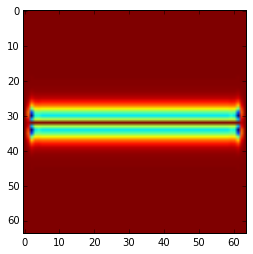

In [38]:
%matplotlib inline
plt.imshow(X[2][:,:,1])

In [45]:
np.diff([1,2,3,4],n=2)

array([0, 0])